Discharge air temperature seems like a good place to start our experiments, in that it is downstream enough that any discords we find might be indicative of a larger problem.

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import urllib.parse
import requests
from sqlalchemy import create_engine

# Open the Database that contains point metadata (PostgresQL)
db_passwd = urllib.parse.quote_plus("gzaUjNfp2K$q0sxQ#^N9")
db_url = 'postgresql://postgresadmin:' + db_passwd + '@localhost:5434/resolute_cloud_dev'
alchemyEngine = create_engine(db_url)
conn = alchemyEngine.connect()

customer_id = 12  # Redico
equipment_type = 42  # AHUs
point_type = 75  #Discharge air temperture
query = '''
        select customer_uuid, metric_id from mapped_points mp
            join point_point_templates ppt on ppt.node_id = mp.id
            join node_tags nt on nt.node_id = mp.parent_id
                where ppt.node_template_id = %s
                and nt.tag_id = %s
                and mp.customer_id = %s;

    '''
sql = query % (point_type, equipment_type, customer_id)
df = pd.read_sql_query(sql, conn)

I'm just trying to get a feel for things, so I'll chose an arbitary ahus and read in a years worth of time series data

In [10]:
url = "http://localhost:4242/api/query?start=6n-ago&ms=true&m=sum:%s.%s" %(
            df.loc[6, 'customer_uuid'], df.loc[6, 'metric_id'])
r = requests.get(url)
ts = r.json()[0]['dps']
series = pd.Series(ts)

Chatting with Justin, there's way too much precision in this data. Temperatures sensors are only accurate to a degree or two. Round the samples to an integer value.

In [31]:
series = series.round(decimals=0)

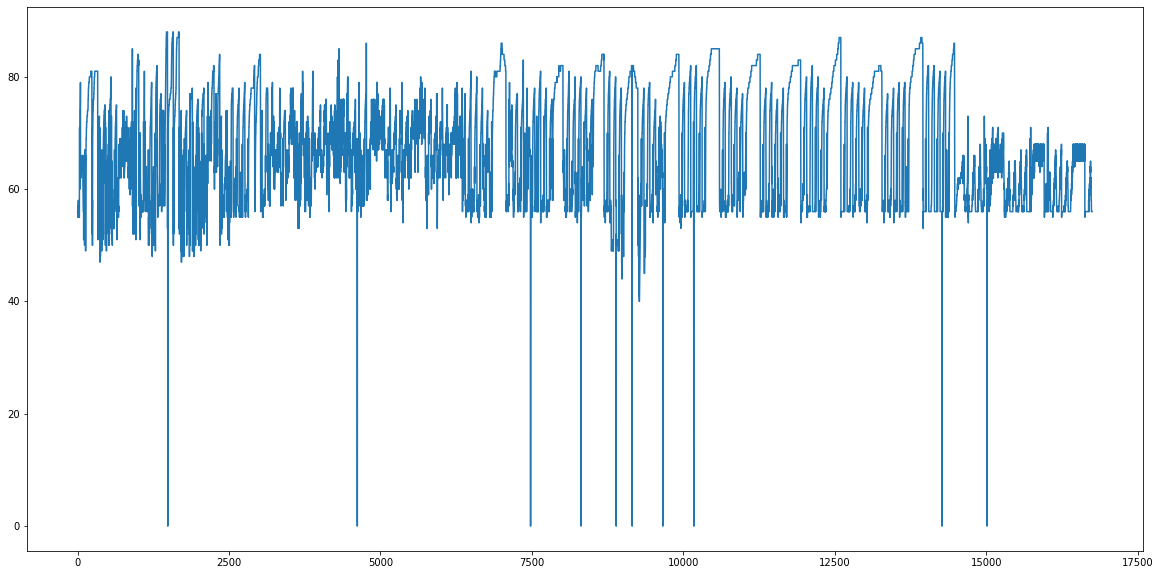

In [32]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(np.arange(len(series)), series.values, label = 'test')

So, all the zeros are somewhat unexpected. This is a thermocouple so it probably shouldn't go to zero. Are this zeros or nan?

In [6]:
series.eq(0).any()

True

Okay, so they are zeros. That's pretty weird. There doesn't seem to be a pattern and I don't know of anything that would lead to this as an artifact. I wonder if this is a one-off

In [7]:
series[series == 0]

1594001754671    0.0
1594425605872    0.0
1594940401999    0.0
1597676402798    0.0
1598992410461    0.0
1601522258407    0.0
1601999102239    0.0
1606354201991    0.0
1609560110336    0.0
1612379702552    0.0
1615305705920    0.0
1616062591196    0.0
1616589002498    0.0
1616922111205    0.0
1617378459780    0.0
1617840070577    0.0
1621537205704    0.0
1622207758871    0.0
dtype: float64

What does the value immediately proceeding the zeros look like?

In [29]:
s2 = series.reset_index()

In [58]:
s2[s2[0] == 0].index

Int64Index([ 4748,  5205,  5725,  8330,  9786, 12589, 13119, 17852, 20662,
            23791, 27431, 28011, 28252, 28755, 29267],
           dtype='int64')

In [61]:
s2.iloc[29267]

index    1617840070577
0                  0.0
Name: 29267, dtype: object

In [62]:
s2.iloc[29266]

index    1617838360650
0            53.799999
Name: 29266, dtype: object

So, the value immediately proceeding the zero value is actually missing. Chatting with various people, this means that supervisor lost connectivity and the zero value is "stale". So, that explains the value.

Now, what to do about it? I think we need to create an anomaly so that everyone knows when this happens. But it is likely to screw up the Matrix Profile (which is the point of this of this experiment). First I need to deal with this (and any other) missing data frames

Since these data are "bad" simply filter them out. Then identify any gaps in the data and backfill them with the next values.

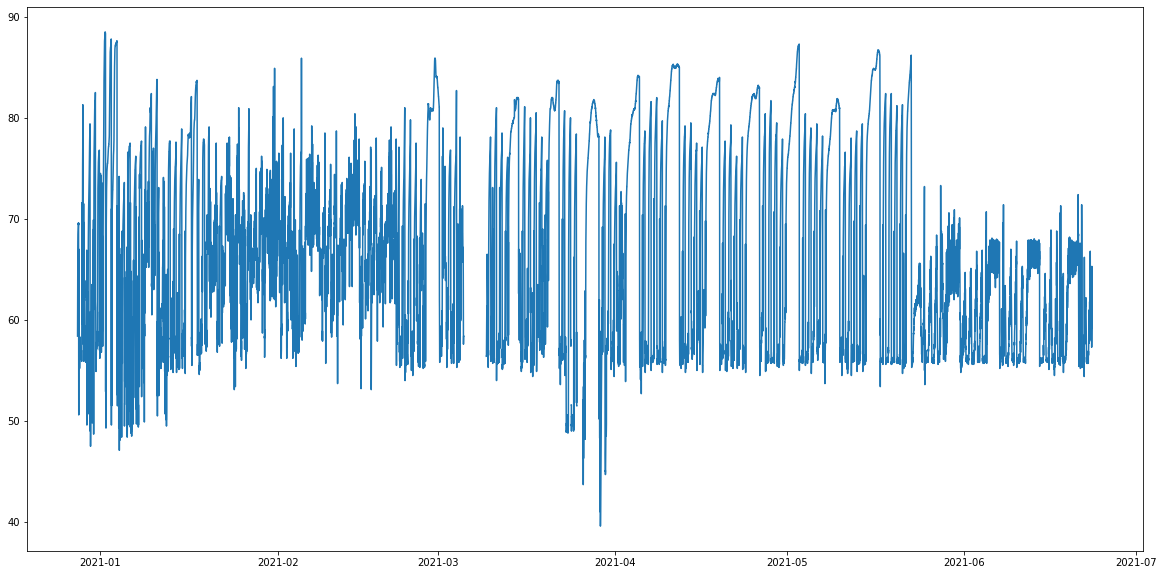

In [11]:
# Remove any samples that are zeros, since they represent stale data
without_zero = series[series != 0]

# Resample the data so that there is one index every fifteen minutes. Some of these sample
# will be NaN, due to longer periods of dropped or stale data
stime = pd.to_datetime(int(int(without_zero.index[0]) / (1000 * 60)) , unit='m', utc=True)
inx = pd.date_range(stime, freq='15T', end= stime + pd.Timedelta(180, unit='d'),tz='UTC')
df2 = without_zero.reset_index(name="sample").rename(columns={"index" : "read_date"})
df2['read_date'] = pd.to_datetime(df2['read_date'], unit='ms', utc=True, origin='unix')
df2 = df2.set_index('read_date')
time_series = df2.reindex(inx, method='nearest', limit=2)

# We want the time series to start on the "natural" boundary of 12:15am (00:15:00)
# on Monday morning, building local. This alignment helps dumping missing data.
# Note, from here on in, time stamps are in local time.
time_series = time_series.tz_convert('US/Eastern')
time_series = time_series.loc[time_series[time_series.index.dayofweek == 0].index[1]:]

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(time_series.index, time_series['sample'].values, label = 'Time Series in Local time')

How much data is still missing. Best way to find out is to graph it,

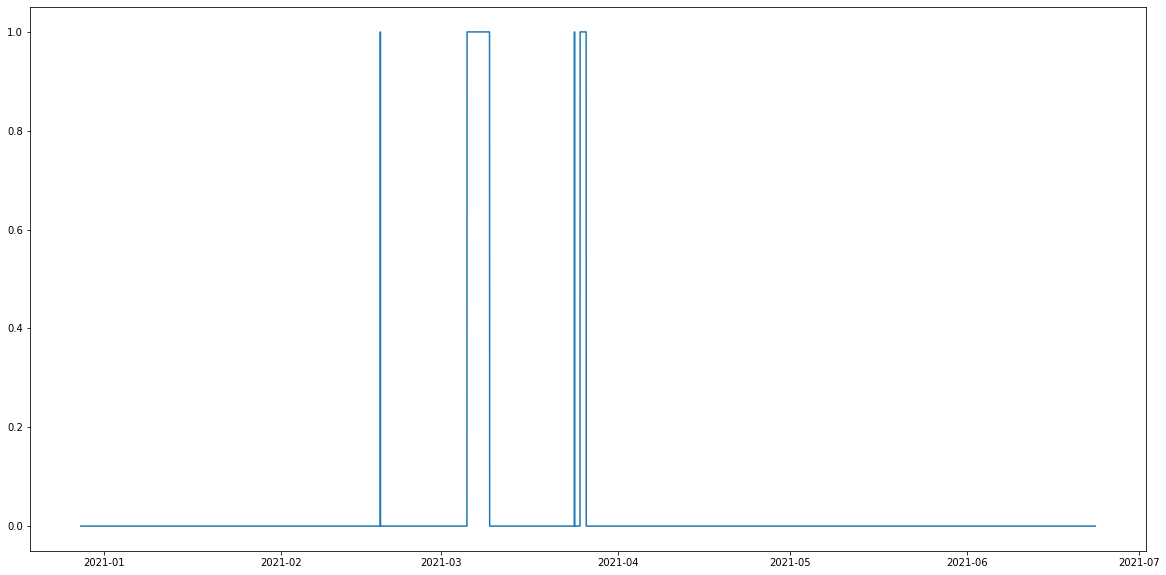

In [12]:
time_series['missing'] = pd.isnull(time_series['sample']) + 0
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(time_series.index, time_series['missing'].values, label = 'missing')

Some of these gaps are really large, so I don't want to simply "connect the dots", which is guaranteed to cause a discord. I also can't drop a sample window because it results in a lose of too much data for month long windows. I'm going to try to copy data from the previous week. Yes, a lot can change in a week, but I think that might be the best simple alternative.

In [13]:
time_series['last_week'] = time_series['sample'].shift(7 * 24 * 4)
time_series['corrected'] = time_series['sample'].fillna(time_series['last_week'])
time_series['corrected']

2020-12-28 00:15:00-05:00    58.400002
2020-12-28 00:30:00-05:00    61.200001
2020-12-28 00:45:00-05:00    63.299999
2020-12-28 01:00:00-05:00    64.400002
2020-12-28 01:15:00-05:00    65.500000
                               ...    
2021-06-23 08:00:00-04:00    65.300003
2021-06-23 08:15:00-04:00    63.500000
2021-06-23 08:30:00-04:00    59.200001
2021-06-23 08:45:00-04:00    59.200001
2021-06-23 09:00:00-04:00    59.200001
Freq: 15T, Name: corrected, Length: 17024, dtype: float64

In [14]:
time_series

,sample,missing,last_week,corrected
2020-12-28 00:15:00-05:00,58.400002,0,NaN,58.400002
2020-12-28 00:30:00-05:00,61.200001,0,NaN,61.200001
2020-12-28 00:45:00-05:00,63.299999,0,NaN,63.299999
2020-12-28 01:00:00-05:00,64.400002,0,NaN,64.400002
2020-12-28 01:15:00-05:00,65.500000,0,NaN,65.500000
...,...,...,...,...
2021-06-23 08:00:00-04:00,65.300003,0,58.299999,65.300003
2021-06-23 08:15:00-04:00,63.500000,0,57.799999,63.500000
2021-06-23 08:30:00-04:00,59.200001,0,57.299999,59.200001
2021-06-23 08:45:00-04:00,59.200001,0,56.599998,59.200001


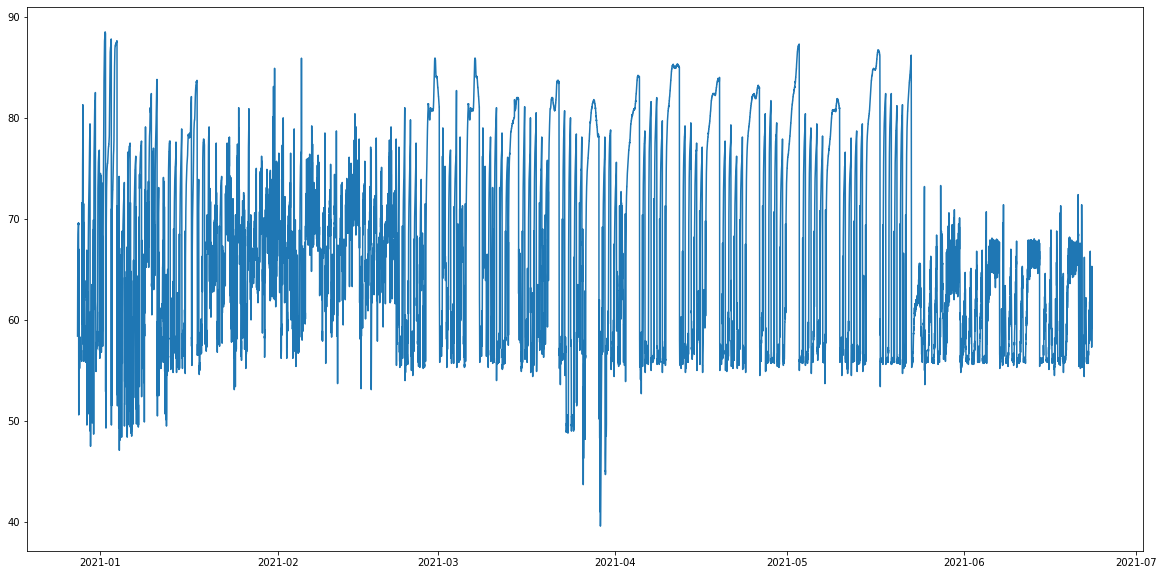

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(time_series.index, time_series['corrected'].values, label = 'missing')

Checking 1 day motifs

/usr/local/Caskroom/miniconda/base/envs/RCR/lib/python3.6/site-packages/matrixprofile/visualize.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


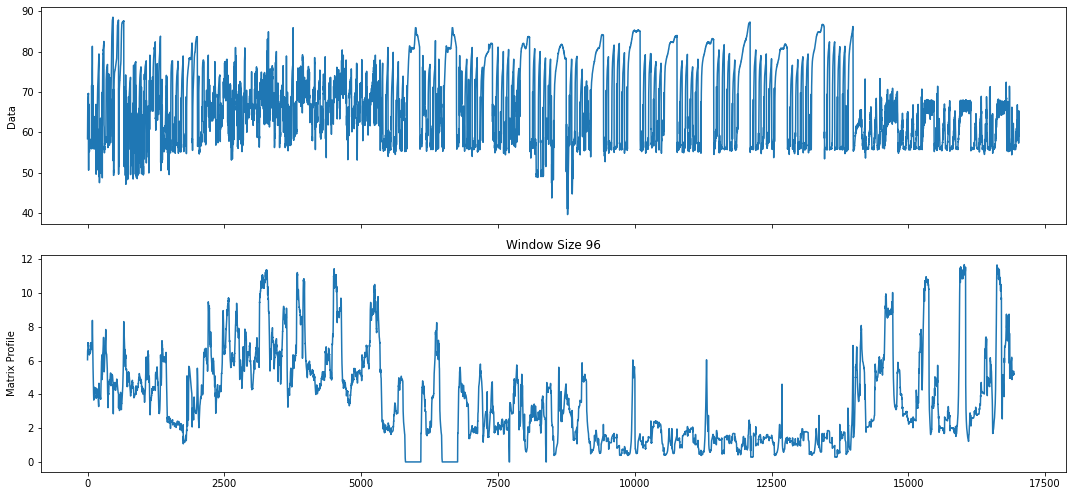

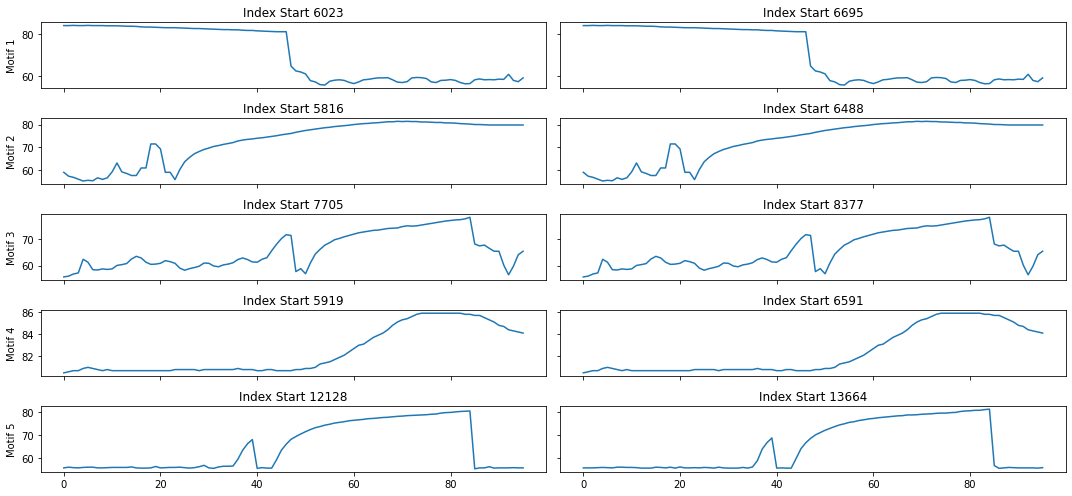

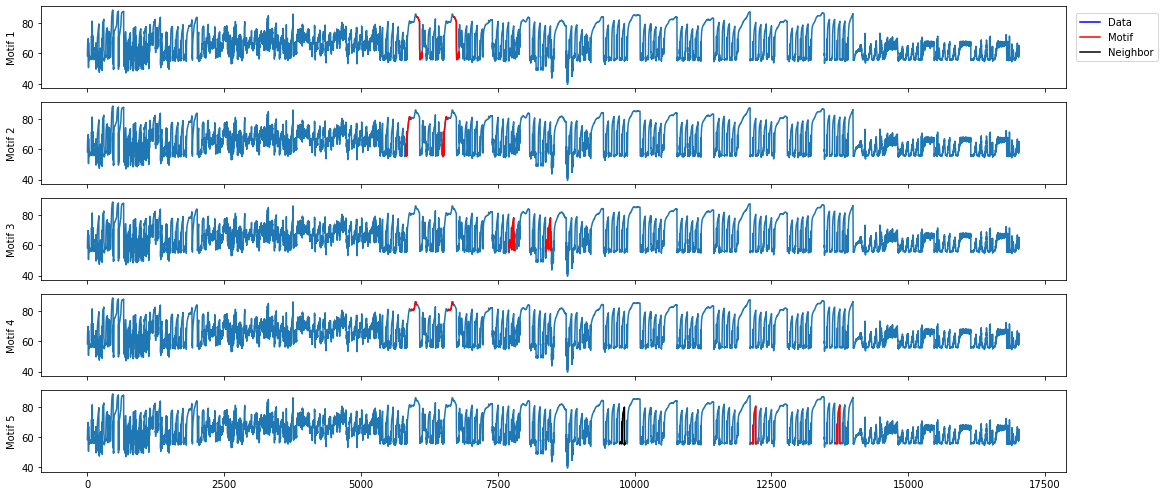

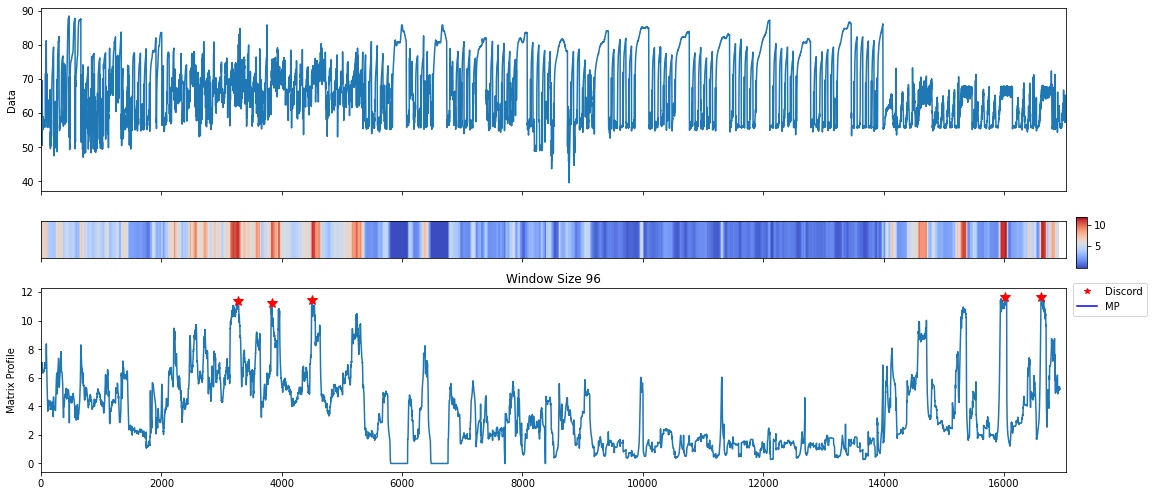

In [16]:
import matrixprofile as mp

window_size=24*4
profile = mp.compute(time_series['corrected'].values, window_size)
profile = mp.discover.motifs(profile, k=5, exclusion_zone=window_size)
profile = mp.discover.discords(profile, k=5, exclusion_zone=window_size)
figures = mp.visualize(profile)

In [100]:
profile

{'mp': array([7.4654331 , 7.30737365, 7.11108591, ..., 2.77040124, 2.77040124,
        2.77040124]),
 'pi': array([ 6048, 13629, 13630, ..., 16455, 16456, 16457]),
 'rmp': None,
 'rpi': None,
 'lmp': None,
 'lpi': None,
 'metric': 'euclidean',
 'w': 96,
 'ez': 0,
 'join': False,
 'sample_pct': 1,
 'data': {'ts': array([56., 60., 62., ..., 56., 56., 56.]), 'query': None},
 'class': 'MatrixProfile',
 'algorithm': 'mpx',
 'motifs': [{'motifs': [6481, 7153], 'neighbors': []},
  {'motifs': [6578, 7250], 'neighbors': []},
  {'motifs': [6675, 7347], 'neighbors': []},
  {'motifs': [8377, 9049], 'neighbors': []},
  {'motifs': [12001, 13336], 'neighbors': []}],
 'discords': array([10657, 11977, 16625,  5180,  4506])}

Motifs are plotted above. Plot the discords.

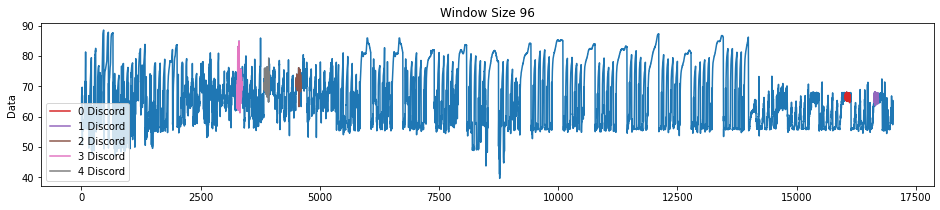

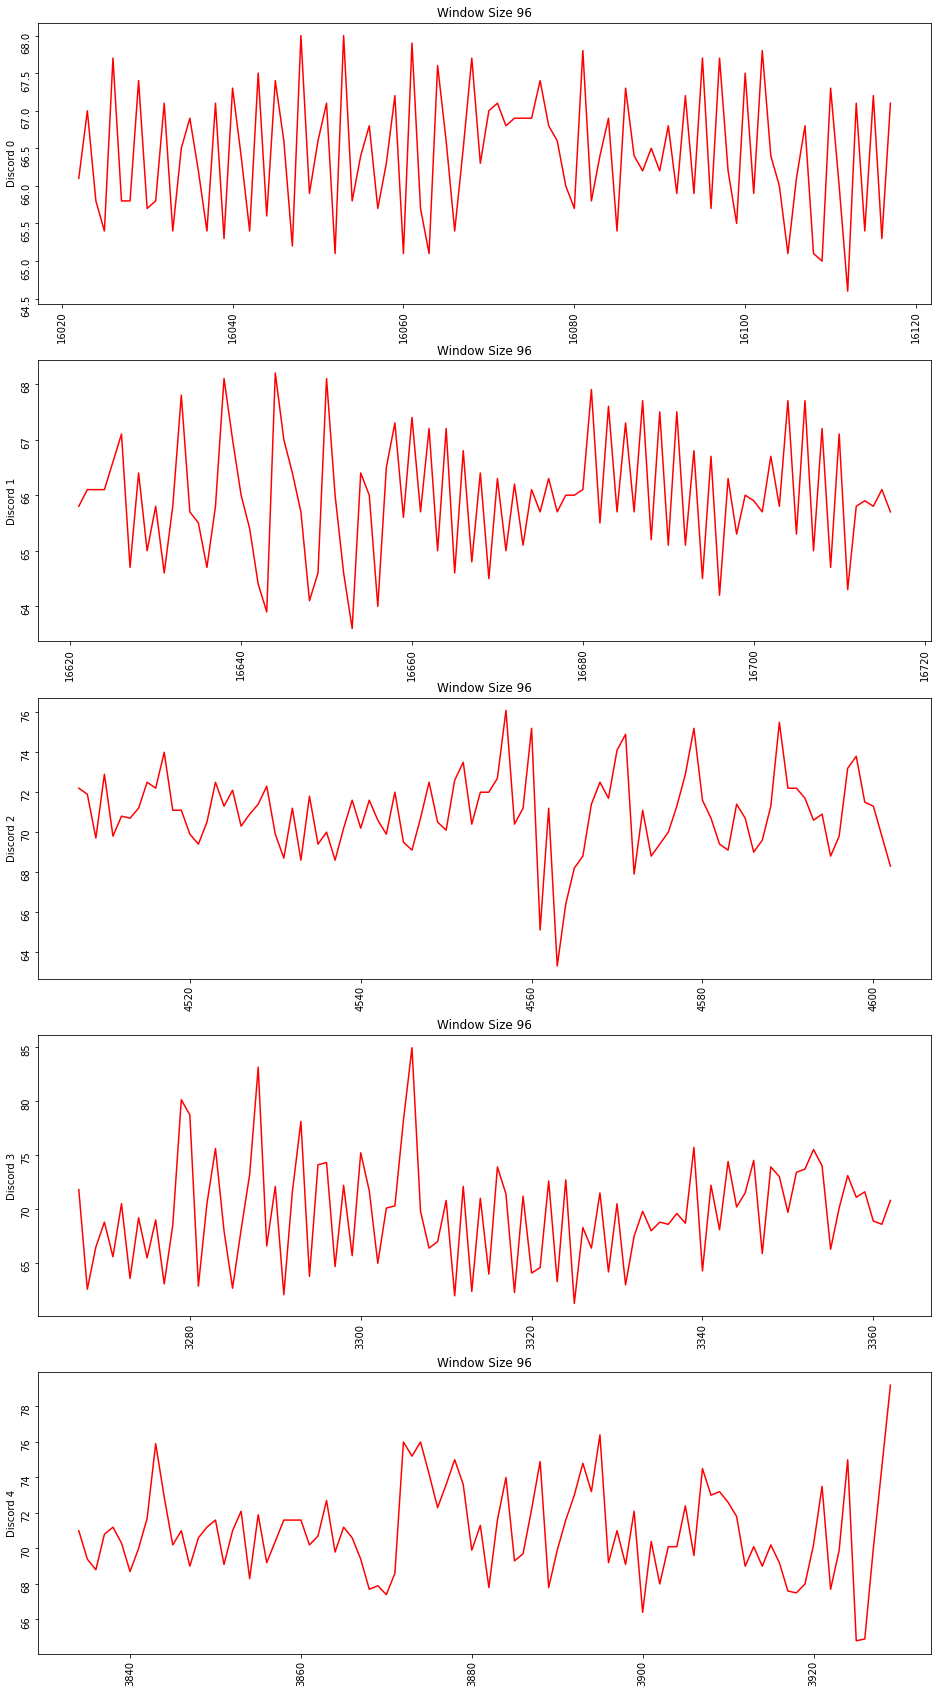

In [17]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16,3))
ax.plot(np.arange(len(profile['data']['ts'])), profile['data']['ts'])
ax.set_title('Window Size {}'.format(str(window_size)))
ax.set_ylabel('Data')

for i,discord in enumerate(profile['discords']):
    x = np.arange(discord, discord + profile['w'])
    y = profile['data']['ts'][discord:discord + profile['w']]
    ax.plot(x, y, c='C'+str(i+3),label="{} Discord".format(i))
plt.legend()
plt.show()

fig, ax = plt.subplots(len(profile['discords']), 1, figsize=(16,30))

i = 0
for discord in profile['discords']:
    x = np.arange(discord, discord + profile['w'])
    y = profile['data']['ts'][discord:discord + profile['w']]
    # ax[i].plot(np.arange(len(profile['data']['ts'])), profile['data']['ts'])
    ax[i].set_title('Window Size {}'.format(str(window_size)))
    ax[i].set_ylabel('Discord {}'.format(i))
    ax[i].tick_params(labelrotation=90)
    ax[i].plot(x, y, c='r')
    i += 1
plt.show()

/usr/local/Caskroom/miniconda/base/envs/RCR/lib/python3.6/site-packages/matrixprofile/visualize.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


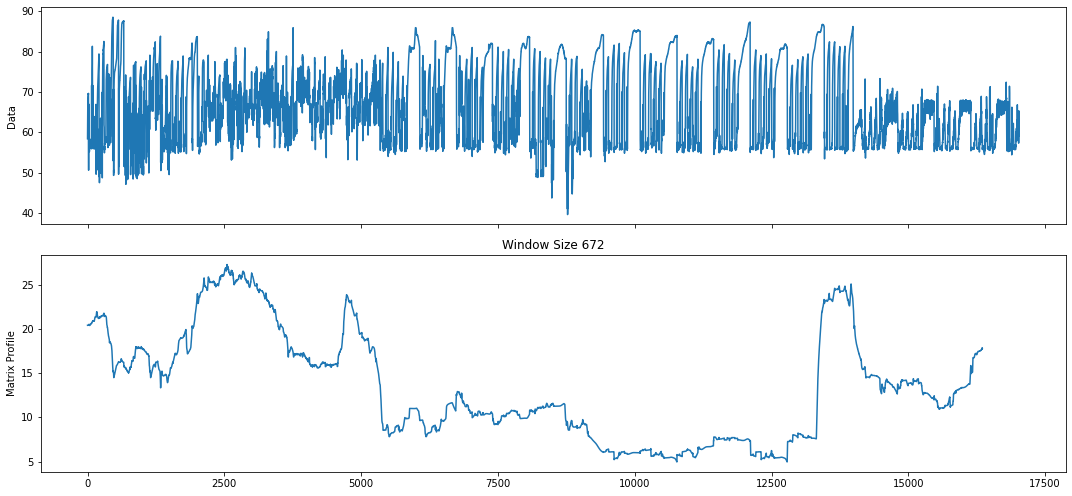

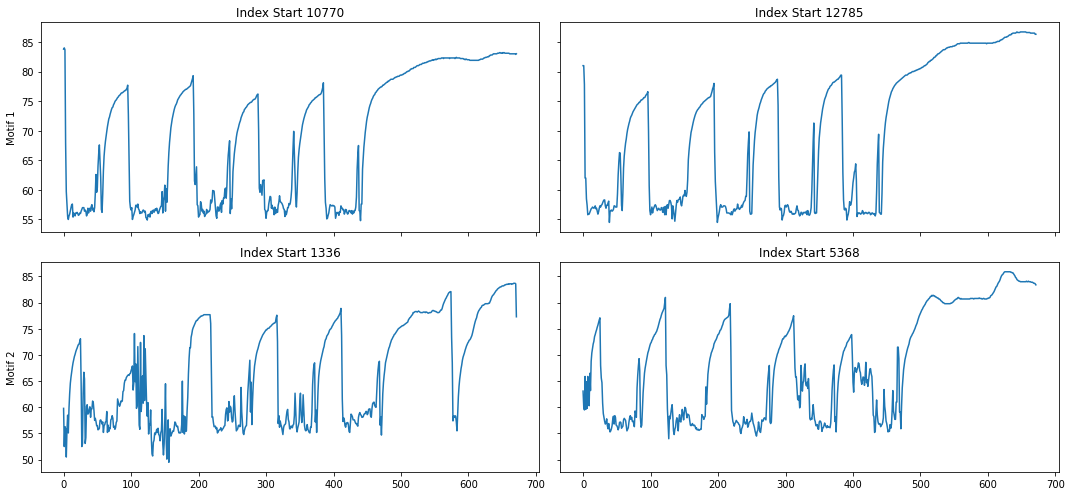

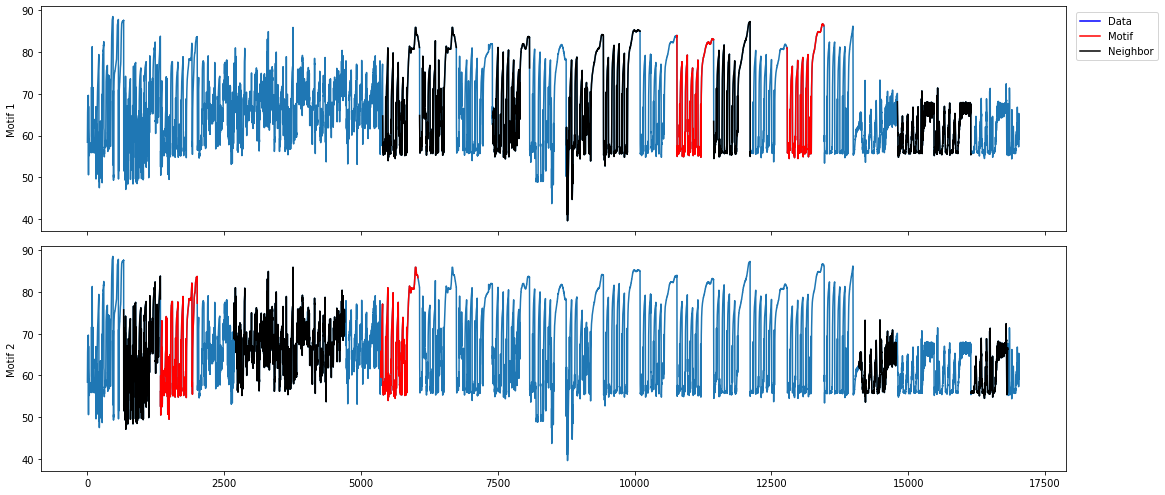

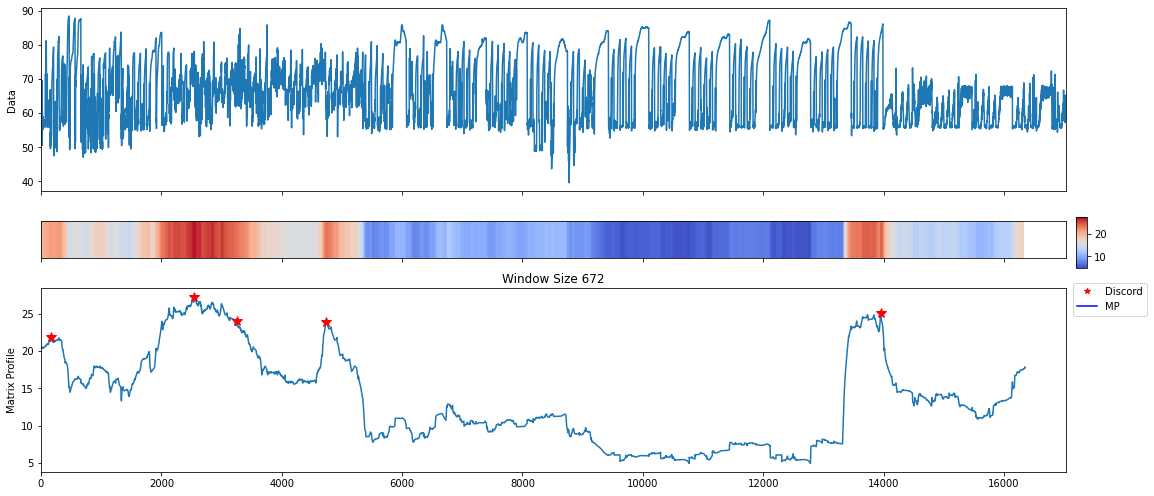

In [18]:
window_size=24*4*7
profile = mp.compute(time_series['corrected'].values, window_size)
profile = mp.discover.motifs(profile, k=5, exclusion_zone=window_size)
profile = mp.discover.discords(profile, k=5, exclusion_zone=window_size)
figures = mp.visualize(profile)

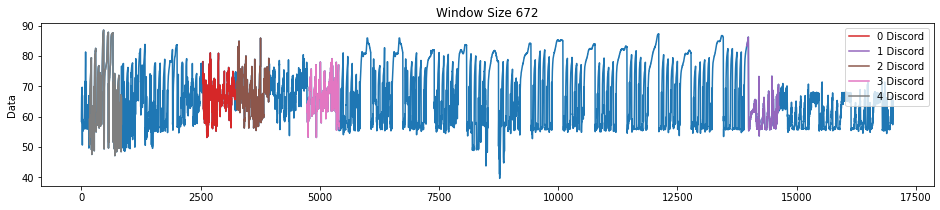

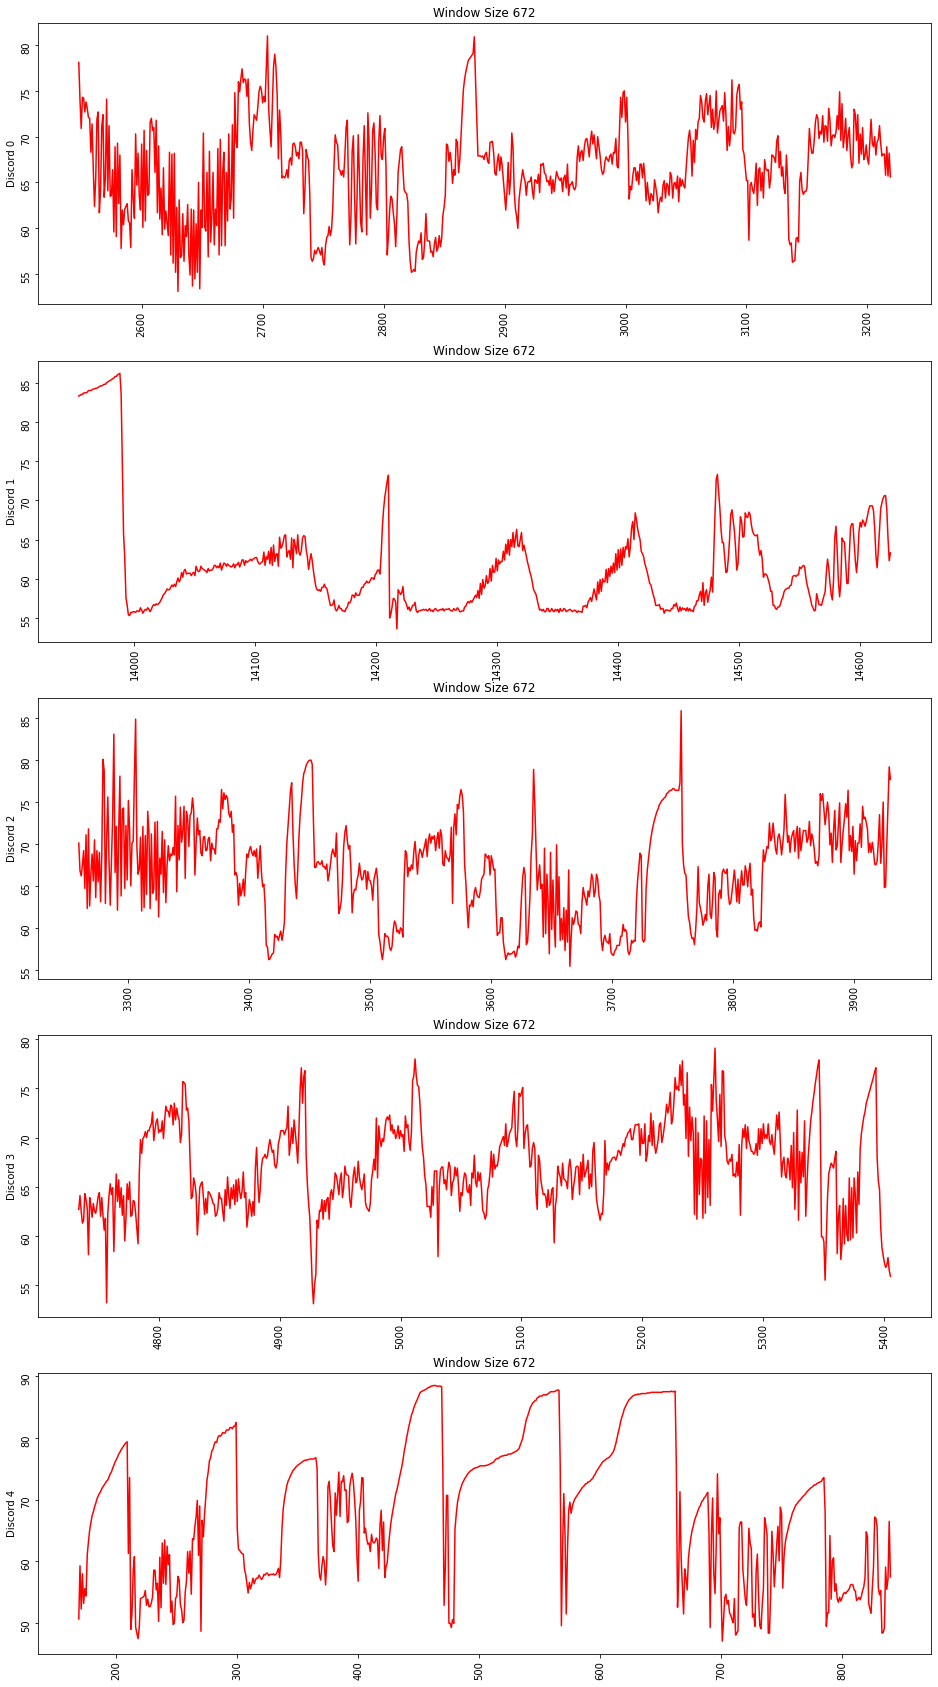

In [19]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16,3))
ax.plot(np.arange(len(profile['data']['ts'])), profile['data']['ts'])
ax.set_title('Window Size {}'.format(str(window_size)))
ax.set_ylabel('Data')

for i,discord in enumerate(profile['discords']):
    x = np.arange(discord, discord + profile['w'])
    y = profile['data']['ts'][discord:discord + profile['w']]
    ax.plot(x, y, c='C'+str(i+3),label="{} Discord".format(i))
plt.legend()
plt.show()

fig, ax = plt.subplots(len(profile['discords']), 1, figsize=(16,30))

i = 0
for discord in profile['discords']:
    x = np.arange(discord, discord + profile['w'])
    y = profile['data']['ts'][discord:discord + profile['w']]
    # ax[i].plot(np.arange(len(profile['data']['ts'])), profile['data']['ts'])
    ax[i].set_title('Window Size {}'.format(str(window_size)))
    ax[i].set_ylabel('Discord {}'.format(i))
    ax[i].tick_params(labelrotation=90)
    ax[i].plot(x, y, c='r')
    i += 1
plt.show()